In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

plt.rcParams['figure.figsize'] = [15,10]

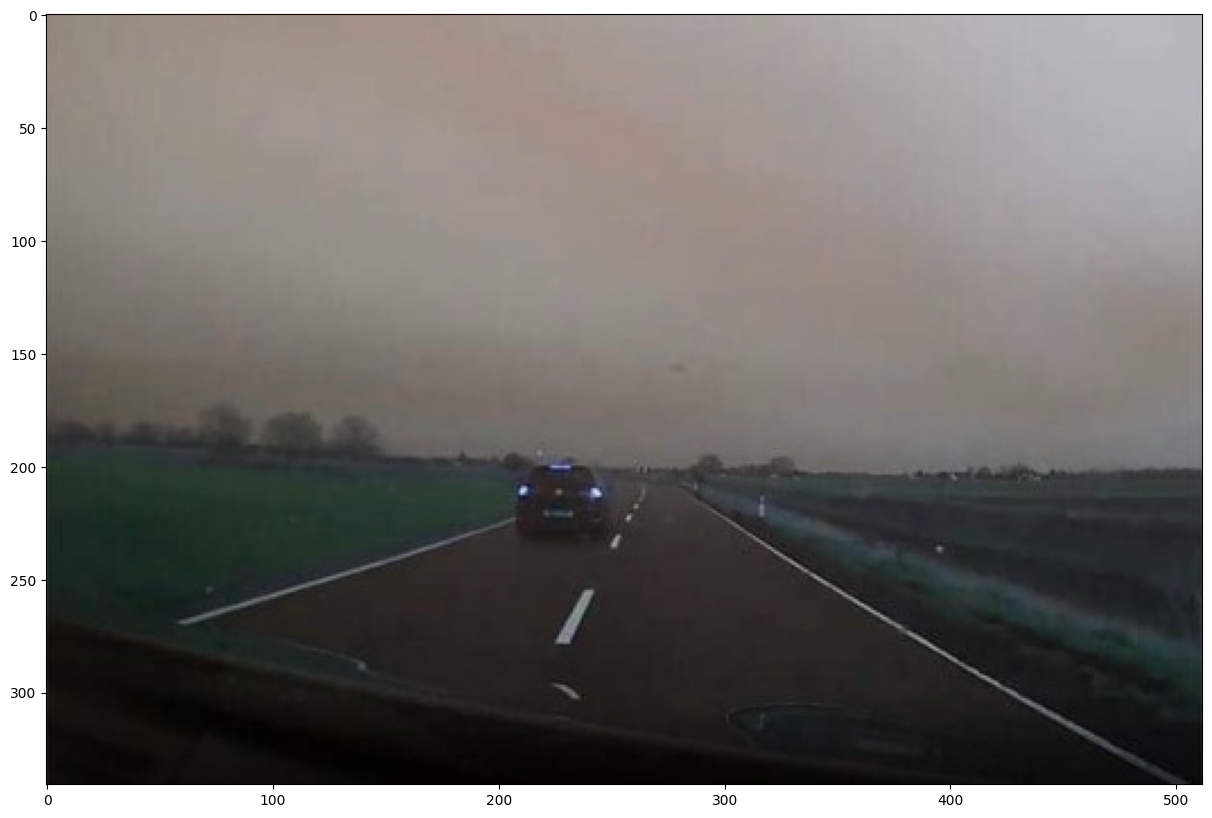

In [3]:
img = cv2.imread('../lab4_Verenchuk_Stanislav/data/dashcam.jpg')
ing = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [4]:
# 3 Перетворення зображення у grayscale
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [6]:
# 4 Отримати карту краю
# Підказка: ви можете використовувати детектор краю Canny з th_low = 100, th_high = 150
th_low = 100
th_high = 150
edges = cv2.Canny(gray, threshold1=th_low, threshold2=th_high)


(<Axes: title={'center': 'Межі'}>,
 Text(0.5, 1.0, 'Межі'))

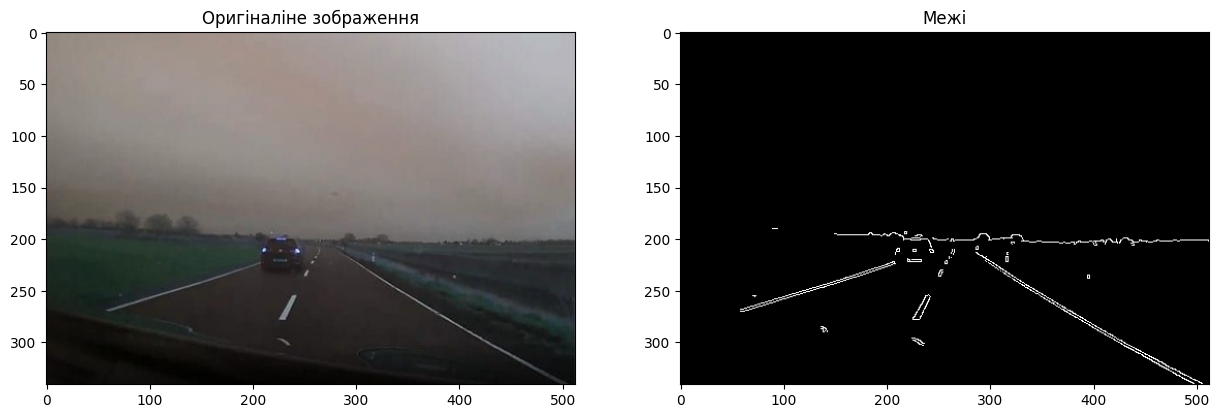

In [7]:
# 5 Відобразити зображення
plt.subplot(121), plt.imshow(img), plt.title('Оригіналіне зображення')
plt.subplot(122), plt.imshow(edges, cmap='gray'), plt.title('Межі')

In [48]:
# 6 Застосувати трансфомацію Гафа, щоб параметризувати межі
rho_res = 5
theta_res = np.deg2rad(5) # градуси в радіанах
threshold = 90 # трешхолд для голосів в акумуляторі

lines = cv2.HoughLines(edges, rho=rho_res, theta=theta_res, threshold=threshold) 

# Видалення непотрібних вимірів
if lines is not None:
    lines = lines[:, 0, :]

(<Axes: title={'center': 'Лінії Гафа'}>,
 Text(0.5, 1.0, 'Лінії Гафа'))

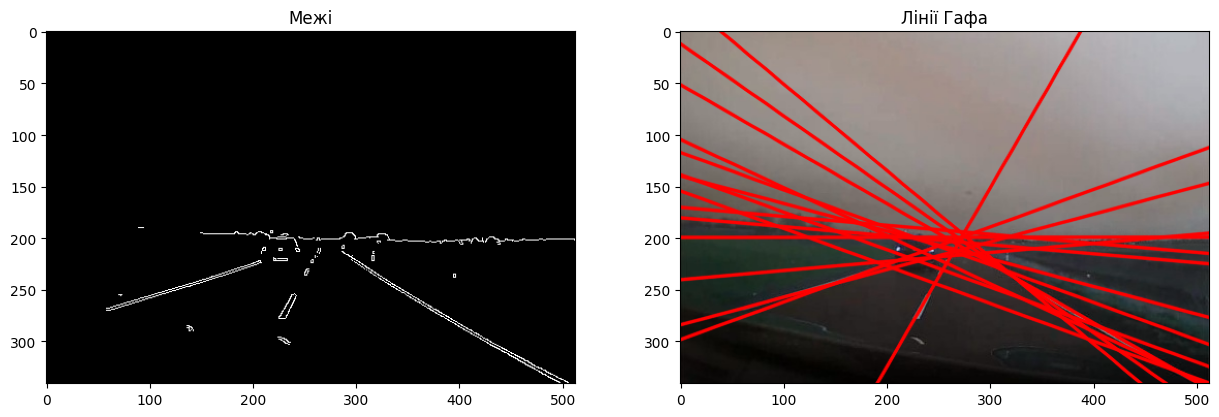

In [49]:
# 7 Відобразити результат ліній Гафа
result = np.copy(img)

for line in lines:
    rho = line[0]
    theta = line[1]
    #Перетворення у декартову форму для побудови лінії
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    
    cv2.line(result, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Межі')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Лінії Гафа')

In [12]:
# 8 Фільтрація ліній, які визначені як горизонтальні (90 градусів (+/- 15 градусів))
filtered_lines = []

theta_deg = 90
margin = 15
theta_min = np.deg2rad(theta_deg - margin)
theta_max = np.deg2rad(theta_deg + margin)

for line in lines:
    # витягти тета для поточної лінії (функція Гафа працює з радіанами)
    rho = line[0]
    theta = line[1]
    
    # Залишити лінію, якщо тета не горизонтальне
    # Видаляємо лінії, якщо theta ≈ 90° ± 15°
    if not (theta_min <= theta <= theta_max):
        filtered_lines.append(line)

# Перетворення назад у NumPy-масив
filtered_lines = np.array(filtered_lines)

(<Axes: title={'center': 'Лінії Гафа'}>,
 Text(0.5, 1.0, 'Лінії Гафа'))

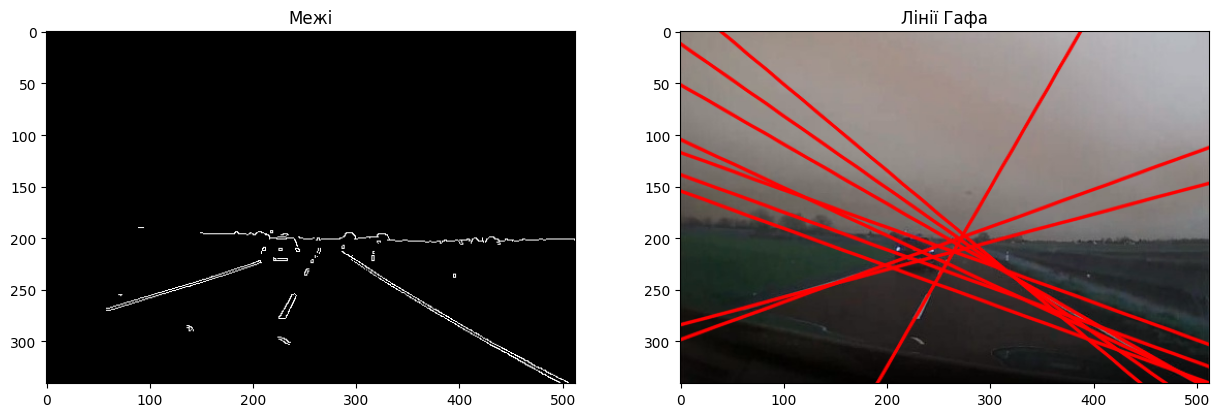

In [14]:
# 9 Відобразити результат фільтрації після усунення горизонтальних ліній
result = np.copy(img)

for line in filtered_lines:
    rho = line[0]
    theta = line[1]
    #Перетворення у декартову форму для побудови лінії
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))

    cv2.line(result, pt1, pt2, (255, 0, 0), 2, cv2.LINE_AA)

plt.subplot(121), plt.imshow(edges, cmap='gray'), plt.title('Межі')
plt.subplot(122), plt.imshow(result, cmap='gray'), plt.title('Лінії Гафа')

In [27]:
from sklearn.cluster import KMeans

# 10. Застосування K-Means кластеризації для параметрів ліній (rho, theta)
kmeans1 = KMeans(n_clusters=3, random_state=0).fit(filtered_lines)
kmeans2 = KMeans(n_clusters=4, random_state=0).fit(filtered_lines)

# Центри кластерів — це три основні лінії (в параметричній формі)
cluster_centers1 = kmeans1.cluster_centers_
cluster_centers2 = kmeans2.cluster_centers_

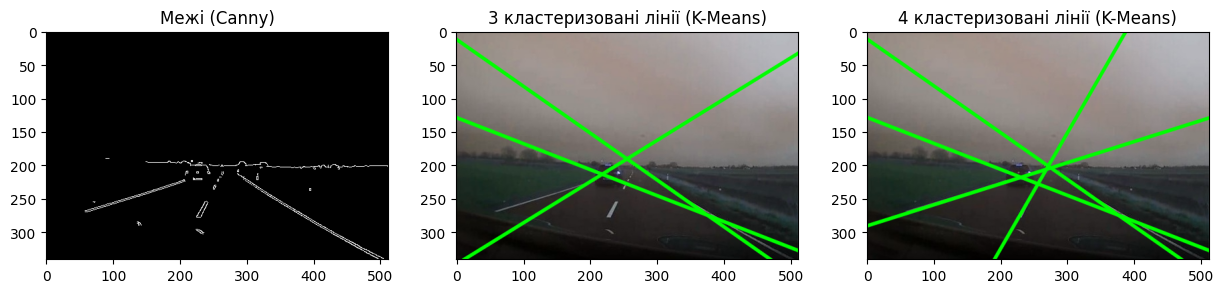

In [29]:
# 11 Відобразити результат фільтрації ліній
result1 = np.copy(img)
result2 = np.copy(img)

for center in cluster_centers1:
    rho = center[0]
    theta = center[1]

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))

    cv2.line(result1, pt1, pt2, (0, 255, 0), 3, cv2.LINE_AA)  # Зелені лінії

for center in cluster_centers2:
    rho = center[0]
    theta = center[1]

    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho

    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))

    cv2.line(result2, pt1, pt2, (0, 255, 0), 3, cv2.LINE_AA)  # Зелені лінії


# Відображення
plt.subplot(131), plt.imshow(edges, cmap='gray'), plt.title('Межі (Canny)')
plt.subplot(132), plt.imshow(result1), plt.title('3 кластеризовані лінії (K-Means)')
plt.subplot(133), plt.imshow(result2), plt.title('4 кластеризовані лінії (K-Means)')
plt.show()


# 1. Як виглядає фінальний результат? Чи є в ньому щось дивного? Наскільки він точний?
Фінальний результат виглядає досить добре.
Для трьох кластеризованих ліній крайні лінії дороги чітко виражені зеленими лініями, але немає лінії, яка показує розмітку дороги. Натомість присутня "дивна" перпендикулярна лінія.
Для чотирьох кластеризованих ліній крайні лінії дороги і лінія розмітки чітко виражені зеленими лініями Також присутня "дивна" перпендикулярна лінія.

# Як ви вважаєте, чи важлива роздільна здатністть перетворення Гафа для отримання хорошого результату? (Для відповіді на питання проведіть експеримент, спробуйте замість 5 градусів значення 1, 2, 10, 15)
Так, роздільна здатність 'theta_res' у перетворенні Гафа має суттєвий вплив на результат.
Я провів експерименти із запропонованими значеннями:
- 1, 2 градуси — знаходить занадто багато схожих ліній, що призводить до «зашумленого» результату (зайві паралельні лінії).
- 5 градусів — оптимальний варіант: досить точний, але не створює надлишкових ліній.
- 10, 15 градусів — багато справжніх ліній втрачаються або об'єднуються, точність зменшується.

# Як ви вважаєте, чи важливий поріг акумулятора перетвонення Гафа для отримання хорошого результату? Чому? Якщо ми візьмемо інші значення трешхолдера для акумулятора, то що ми отримаємо?
Як і у випадку з роздільною здатністю 'theta_res' значення порогу акумулятора 'threshold' впливає на якість результату. Низькі значення порогу призводять до хибних ліній, шуму, горизонтальних та випадкових меж. При надто високих значення порогу справжні лінії можуть не потрапити у фінальний результат.